In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as  plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 22
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE    
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    #print(image_batch[0].numpy())
    print(image_batch[0].shape)

(256, 256, 3)


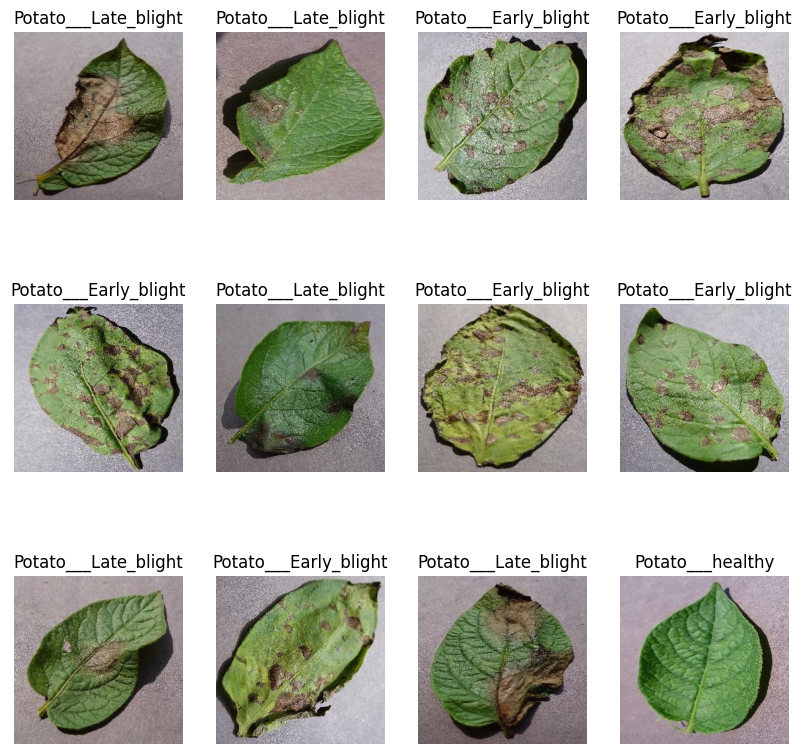

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1,
                               test_split=0.1, shuffle=True, shuffle_size=10000):
    # Ensure splits sum to 1.0
    assert abs((train_split + test_split + val_split) - 1.0) < 1e-6, "Splits must sum to 1.0"

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


# Example usage:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
 tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
 tf.keras.layers.Rescaling(1.0/255),
])


In [13]:
data_augmentation = tf.keras.Sequential([
 tf.keras.layers.RandomFlip("horizontal_and_vertical"),
 tf.keras.layers.RandomRotation(0.2),
])


In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

In [15]:
from tensorflow.keras import layers, models

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (22, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (22, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (22, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (22, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (22, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (22, 60, 60, 64)         

In [17]:
model.compile(
 optimizer='adam',

loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
 metrics=['accuracy']
)


In [18]:
story = model.fit(
 train_ds,
 batch_size=BATCH_SIZE,
 validation_data=val_ds,
 verbose=1,
 epochs=5,
)


Epoch 1/5
78/78 [==============================] - 102s 1s/step - loss: 0.8184 - accuracy: 0.5818 - val_loss: 0.4407 - val_accuracy: 0.8434
Epoch 2/5
78/78 [==============================] - 92s 1s/step - loss: 0.4031 - accuracy: 0.8096 - val_loss: 0.3148 - val_accuracy: 0.8889
Epoch 3/5
78/78 [==============================] - 90s 1s/step - loss: 0.2794 - accuracy: 0.8843 - val_loss: 0.2692 - val_accuracy: 0.8889
Epoch 4/5
78/78 [==============================] - 92s 1s/step - loss: 0.1759 - accuracy: 0.9322 - val_loss: 0.1423 - val_accuracy: 0.9444
Epoch 5/5
78/78 [==============================] - 93s 1s/step - loss: 0.1716 - accuracy: 0.9299 - val_loss: 0.1001 - val_accuracy: 0.9899


In [19]:
scores = model.evaluate(test_ds)

11/11 [==============================] - 5s 306ms/step - loss: 0.1774 - accuracy: 0.9339


first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 642ms/step
predicted label: Potato___Late_blight


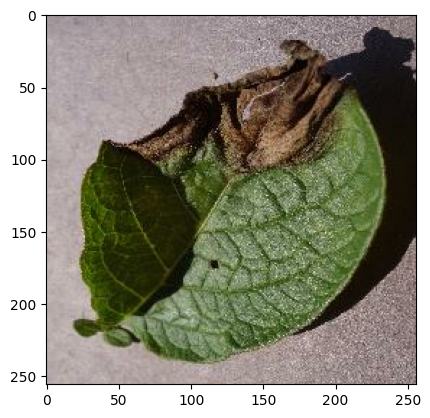

In [20]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
 #print(images_batch[0])
 first_image = images_batch[0].numpy().astype('uint8')
 first_label = labels_batch[0].numpy()

 print("first image to predict")
 plt.imshow(first_image)
 print("actual label:",class_names[first_label])

 batch_prediction = model.predict(images_batch)
 print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [21]:
def predict(model, img):
 img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
 img_array = tf.expand_dims(img_array, 0)
 predictions = model.predict(img_array)
 predicted_class = class_names[np.argmax(predictions[0])]
 confidence = round(100 * (np.max(predictions[0])), 2)
 return predicted_class, confidence


1/1 [==============================] - 0s 81ms/step


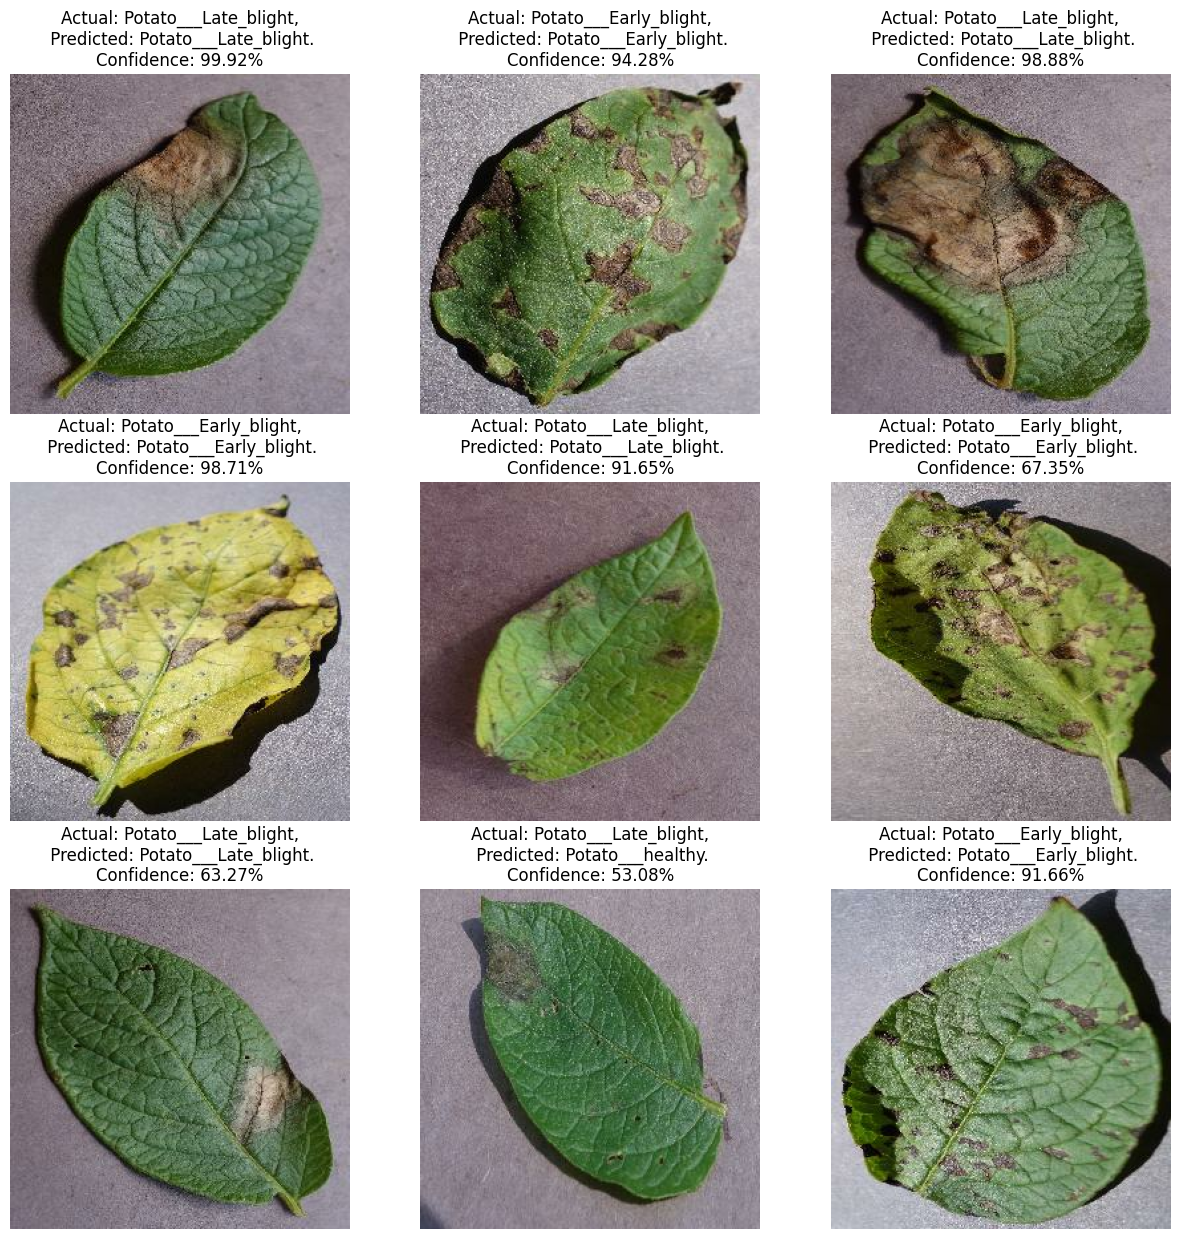

In [25]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\nConfidence: {confidence}%")
        plt.axis("off")


In [37]:
import os

models_dir = r"C:\Users\senth\Placement Training\potato\models"
os.makedirs(models_dir, exist_ok=True)  # This will create the folder if it doesn't exist

model_version = max([int(i) for i in os.listdir(models_dir) + ['0']]) + 1
model.save(f"{models_dir}\\{model_version}")
model.save(r"C:\Users\senth\Placement Training\potato\potatoes.h5")


INFO:tensorflow:Assets written to: C:\Users\senth\Placement Training\potato\models\1\assets


INFO:tensorflow:Assets written to: C:\Users\senth\Placement Training\potato\models\1\assets
